In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dim = 10
batch_size = 16

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.Linear(64, dim)
        )

    def forward(self, x):
        z = self.layers(x)
        return z

In [2]:
class Decoder(torch.nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, 64),
            nn.BatchNorm1d(64),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 384),
            nn.Tanh()
        )
    def forward(self, z):
        x_hat = self.layers(z)
        return x_hat

In [3]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat

In [4]:
from torch.distributions import Normal

class VariationalEncoder(torch.nn.Module):
    def __init__(self):
        super(VariationalEncoder, self).__init__()
        self.fc1 = nn.Linear(384, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, dim)
        self.fc4 = nn.Linear(64, dim)
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(64)
        self.N = Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = self.bn1(self.fc1(x))
        x = F.relu(x)
        x = self.bn2(self.fc2(x))
        x = F.relu(x)
        mu = self.fc3(x)
        sigma = torch.exp(self.fc4(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 0.5).sum()
        return z

class VariationalAutoencoder(torch.nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.enc = VariationalEncoder()
        self.dec = Decoder()

    def forward(self, x):
        z = self.enc(x)
        x_hat = self.dec(z)
        return x_hat

In [5]:
import wandb
import tqdm
import torch.optim

def train_vae(vae, data, epochs):
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="dna2vec-vae",

        # track hyperparameters and run metadata
        config={
            "architecture": "VAE",
            "epochs": epochs
        }
    )
    optim = torch.optim.Adam(vae.parameters(), lr=1e-4)
    wandb.watch(vae, F.mse_loss, log="all", log_freq=1)
    for epoch in range(epochs):
        for i in tqdm.tqdm(range(len(data))):
            x = data[i].to('cuda')
            optim.zero_grad()
            x_hat = vae(x)
            # loss: MSE with KL divergence penalty
            L = F.mse_loss(x, x_hat) + vae.enc.kl
            wandb.log({"loss": L, "epoch": epoch, "batch": i})
            L.backward()
            optim.step()
    return vae

In [6]:
# PATH fix to locate dna2vec package
import os, sys
sys.path.append(os.getcwd() + "/../src")

In [7]:
from inference_models import EvalModel
import torch
import yaml

with open("configs/model_checkpoints.yaml", 'r') as stream:
    checkpoints = yaml.safe_load(stream)

from dna2vec.model import model_from_config

def _load_model_for_inference(alias, device="cuda:3"):
    received = torch.load(checkpoints[alias], map_location="cpu")
    config = received["config"]
    config.model_config.tokenizer_path = checkpoints["tokenizer"]
    encoder, pooling, tokenizer = model_from_config(config.model_config)
    encoder.load_state_dict(received["model"])
    encoder.eval()
    model_params = {
        "tokenizer": tokenizer,
        "model": encoder,
        "pooling": pooling,
    }
    eval_model = EvalModel(
        model_params["tokenizer"],
        model_params["model"],
        model_params["pooling"],
        device = device
    )
    return eval_model

eval_model = _load_model_for_inference("trained-all-longer")

/mnt/SSD5/jshiffer/miniconda3/envs/dna2vec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/SSD5/jshiffer/miniconda3/envs/dna2vec/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
from random import shuffle
from aligners.helpers import load_reference_genome
fasta_file = "/mnt/SSD2/pholur/General_Models/data/thermus_aquaticus/thermus_aquaticus.fasta"
dictionary_of_reference = load_reference_genome(fasta_file)
subsequence_of_reference = dictionary_of_reference["NZ_CP010822.1"]


def get_subsequences(sequence, min_read_length=200, reads_per_step=100, read_length_step=0):
    read_lengths = []
    i = 0
    read_length = min_read_length
    while sum(read_lengths) < len(sequence):
        read_lengths.append(min(read_length, len(sequence)-sum(read_lengths)))
        i += 1
        if i % reads_per_step == 0:
            read_length += read_length_step
    print("Reads up to length", max(read_lengths))
    shuffle(read_lengths)

    start = 0
    subsequences = {}
    i = 0
    for j, read_length in enumerate(read_lengths):
        if batch_size not in subsequences:
            subsequences[batch_size] = []
        if j % batch_size == 0:
            subsequences[batch_size].append([])
        subsequences[batch_size][-1].append(sequence[start:start + read_length].upper())
        start += read_length
    # flatten by one layer
    flattened = []
    for batches_by_size in subsequences.values():
        # no batches under batch_size
        flattened += list(filter(lambda x: len(x) == batch_size, batches_by_size))
    return flattened

In [9]:
def minmax(vec, new_min=-1.0, new_max=1.0):
    tensor = torch.Tensor(vec)
    tensor_min, tensor_max = torch.aminmax(tensor)
    return (tensor - tensor_min)/(tensor_max - tensor_min) * (new_max - new_min) + new_min

In [9]:
batched_reads = get_subsequences(subsequence_of_reference)
batches = []
print("Num. batches:", len(batched_reads))
print("Batch size:", len(batched_reads[0]))
print("Read length:", len(batched_reads[0][0]))
for batch in batched_reads:
    enc = eval_model.encode(batch)
    enc_tensor = minmax(enc)
    batches.append(enc_tensor)
print(enc_tensor.shape)

Reads up to length 200
Num. batches: 674
Batch size: 16
Read length: 200
torch.Size([16, 384])


In [16]:
vae = VariationalAutoencoder().to('cuda')
vae = train_vae(vae, batches, 5)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


100%|██████████| 674/674 [00:50<00:00, 13.29it/s]


In [17]:
torch.save(vae.state_dict(), 'autoencoder.pth')

In [10]:
vae = VariationalAutoencoder().to('cuda')
vae.load_state_dict(torch.load('autoencoder.pth'))

<All keys matched successfully>

MSE Loss: 0.07614373415708542


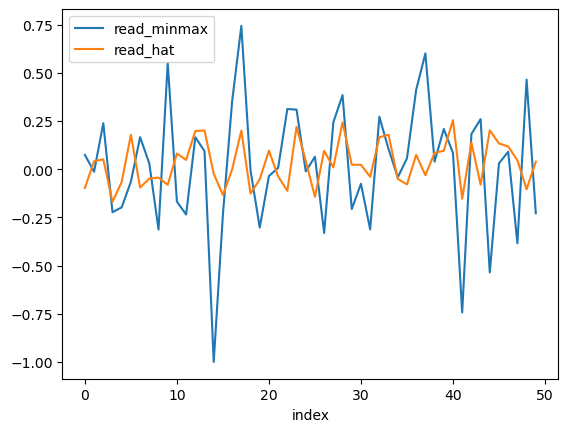

In [13]:
from random import randint
seq = dictionary_of_reference["NZ_CP010823.1"]
rand_idx = randint(0, len(seq) - 201)
read = seq[rand_idx:rand_idx+200]

vae.eval()
read_enc = minmax(eval_model.encode([read])).to('cuda').view(1, 384)
enc = vae.enc(read_enc)
#print(enc)
read_hat = vae(read_enc)
print("MSE Loss:", F.mse_loss(read_enc, read_hat).item())
#print(read_enc)
#print(read_hat)

import matplotlib.pyplot as plt
plt.plot(read_enc[0].detach().cpu().numpy()[:50], label="read_minmax")
plt.plot(read_hat[0].detach().cpu().numpy()[:50], label="read_hat")
plt.xlabel("index")
plt.legend()

## t-SNE Visualization

In [49]:
from sklearn.manifold import TSNE
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import tqdm

vae.eval()

def prepare_cluster_data():
    labels = []
    X = None
    seqs = list(dictionary_of_reference.values())[:10]
    for i in tqdm.tqdm(range(len(seqs))):
        seq = seqs[i]
        for _ in range(50):
            rand_idx = randint(0, len(seq) - 201)
            read = seq[rand_idx:rand_idx+200]
            read_enc = minmax(eval_model.encode([read])).to('cuda').view(1, 384)
            enc = vae.enc(read_enc).detach().cpu().numpy()
            labels.append(i)
            if X is None:
                X = np.array(enc)
            else:
                X = np.vstack([X, enc])
    return X, labels

In [44]:
#Thermus aquaticus
from aligners.helpers import load_reference_genome
fasta_file = "/mnt/SSD2/pholur/General_Models/data/thermus_aquaticus/thermus_aquaticus.fasta"
dictionary_of_reference = load_reference_genome(fasta_file)
print(dictionary_of_reference.keys())

X, labels = prepare_cluster_data()

dict_keys(['NZ_CP010822.1', 'NZ_CP010823.1', 'NZ_CP010824.1', 'NZ_CP010825.1', 'NZ_CP010826.1'])


  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:01<00:00,  4.42it/s]


In [50]:
#Run this cell to substitute Thermus aquaticus with S. erecta
from aligners.helpers import load_reference_genome
fasta_file = "/mnt/SSD5/jshiffer/data/m64044_210515_010435.subreads.ccs.demux.S_erecta--S_erecta.fasta"
dictionary_of_reference = load_reference_genome(fasta_file)
print(dictionary_of_reference.keys())

X, labels = prepare_cluster_data()

dict_keys(['m64044_210515_010435/658/ccs', 'm64044_210515_010435/810/ccs', 'm64044_210515_010435/1144/ccs', 'm64044_210515_010435/1490/ccs', 'm64044_210515_010435/1755/ccs', 'm64044_210515_010435/1757/ccs', 'm64044_210515_010435/1880/ccs', 'm64044_210515_010435/2659/ccs', 'm64044_210515_010435/65662/ccs', 'm64044_210515_010435/66163/ccs', 'm64044_210515_010435/66370/ccs', 'm64044_210515_010435/66540/ccs', 'm64044_210515_010435/66544/ccs', 'm64044_210515_010435/67276/ccs', 'm64044_210515_010435/67495/ccs', 'm64044_210515_010435/68084/ccs', 'm64044_210515_010435/131290/ccs', 'm64044_210515_010435/131622/ccs', 'm64044_210515_010435/131658/ccs', 'm64044_210515_010435/131790/ccs', 'm64044_210515_010435/132160/ccs', 'm64044_210515_010435/132194/ccs', 'm64044_210515_010435/132257/ccs', 'm64044_210515_010435/133557/ccs', 'm64044_210515_010435/133807/ccs', 'm64044_210515_010435/133836/ccs', 'm64044_210515_010435/196742/ccs', 'm64044_210515_010435/197396/ccs', 'm64044_210515_010435/197468/ccs', 

100%|██████████| 10/10 [00:02<00:00,  4.77it/s]


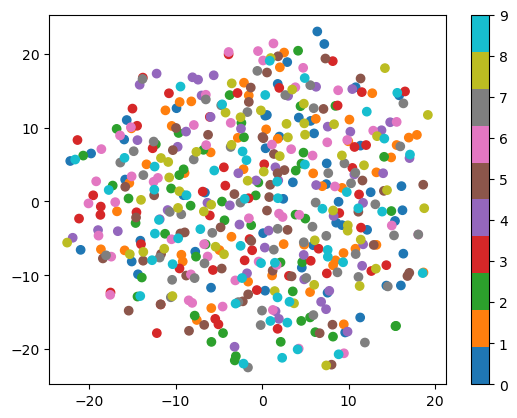

In [51]:
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=labels, cmap='tab10')
plt.colorbar(ticks=list(range(len(dictionary_of_reference.values()))))

## Parametric UMAP

This requires TensorFlow...

In [52]:
from umap.parametric_umap import ParametricUMAP
model = ParametricUMAP(n_components=2, n_neighbors=10)
vectors = model.fit_transform(X)

/mnt/SSD5/jshiffer/miniconda3/envs/dna2vec/lib/python3.11/site-packages/umap/parametric_umap.py:148: UserWarning: tensorflow_probability not installed or incompatible to current                 tensorflow installation. Setting global_correlation_loss_weight to zero.
  warn(


Epoch 1/10


2024-02-26 01:43:06.948922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [1378436]
	 [[{{node Placeholder/_0}}]]
2024-02-26 01:43:06.949360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [1378436]
	 [[{{node Placeholder/_1}}]]
2024-02-26 01:43:07.244073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' 

275/275 [==============================] - 6s 16ms/step - loss: 0.3761
Epoch 2/10
275/275 [==============================] - 4s 16ms/step - loss: 0.3366
Epoch 3/10
275/275 [==============================] - 4s 15ms/step - loss: 0.3290
Epoch 4/10
275/275 [==============================] - 4s 13ms/step - loss: 0.3261
Epoch 5/10
275/275 [==============================] - 4s 14ms/step - loss: 0.3259
Epoch 6/10
275/275 [==============================] - 3s 12ms/step - loss: 0.3256
Epoch 7/10
275/275 [==============================] - 4s 13ms/step - loss: 0.3251
Epoch 8/10
275/275 [==============================] - 4s 13ms/step - loss: 0.3253
Epoch 9/10
275/275 [==============================] - 4s 14ms/step - loss: 0.3252
Epoch 10/10
275/275 [==============================] - 4s 16ms/step - loss: 0.3237


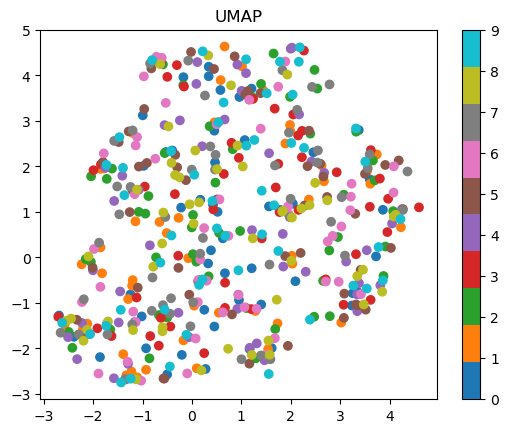

In [54]:
import matplotlib.pyplot as plt
plt.title('UMAP')
plt.scatter(vectors[:,0], vectors[:,1], c=labels, cmap='tab10')
plt.colorbar(ticks=list(range(len(dictionary_of_reference.values()))))